In [1]:
# This code simply loads traces and displays them in a spectrogram and in a plot
# It does not contain any training functions or parameters
# It was created to increase the readability of the main code and to enable the display of the loaded traces (Duh :P)

# This code contains code adapted from Nils Wisiol, sntrup4591761 and ANSSI-FR/ASCAD
# All snippets are marked accordingly as such

# General modules
import sys
import os
import os.path
from pathlib import Path # creating directories

# Load data modules
from numpy import empty, zeros, uint16
from numpy.random import RandomState
import numpy as np
## load cw data
import chipwhisperer as cw
## load ASCAD data
import h5py


# Plot traces
from scipy import signal, fftpack
import matplotlib.pyplot as plt

# Training modules
## CNN
### Model modules
from keras.layers import Input, Conv1D, AveragePooling1D, Flatten, Dense, AveragePooling1D
from keras.models import Model
from keras.optimizers import Adam
### training method modules
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical
from keras.models import load_model
import tensorflow as tf
import random as python_random

## CNN2
### Model modules
from keras.layers import BatchNormalization, GaussianNoise, MaxPooling1D, Dropout

## MLP
### Model modules
from keras.optimizers import RMSprop
from keras.models import Sequential

# plot result
from seaborn import catplot
from pandas import DataFrame

Using TensorFlow backend.
/home/gharra/chipWhisp01/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/gharra/chipWhisp01/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/gharra/chipWhisp01/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/gharra/chipWhisp01/venv/lib/p

In [2]:
# # # Streamlined NTRU Prime: sntrup4591761
# # # Unmodified and unused

# P, Q, W = 761, 4591, 286

# def key_gen(seed):
# 	""" Returns a Streamlined NTRU Prime key. (But does not check invertability) """
# 	# TODO see if this is a good approximation of the key distribution
# 	# this is supposed to give a random, small element of R,
# 	# R = Z[x]/(x**p−x−1), that is invertible in R/3.
# 	# TODO this does not check for invertibility

# 	r = RandomState(seed)
# 	c_values = 2 * r.randint(2, size=W) - 1  # W "small" non-zero coefficients, i.e. -1, 1
# 	c_pos = r.choice(P, W, replace=False)  # choose W positions out of the P possible ones
# 	cs = zeros(P, dtype=uint16)
# 	for i in range(W):  # fill the W non-zero values
# 		cs[c_pos[i]] = c_values[i]
# 	return cs

# def text_gen(seed):
# 	""" Returns a uniformly random from the space of all Streamlined NTRU Prime Ciphertexsts. """
# 	# uniformly random element of R with coefficients being only
# 	# multiple of 3
# 	r = RandomState(seed)
# 	return (r.randint(0, Q, size=P) * 3 // 3) % Q

In [3]:
# ASCAD: Adapted by Mahmoud Gharra to fit the NTRU Prime input

# returns traces and labels, as well as some important global meta_data
def load_database_cw(my_database):
    # load traces
    print("++ Loading projects")
    project = cw.open_project(my_database)
    global KEY_LENGTH, TEXT_LENGTH, SAMPLE_HIGH, TRAINING_SLICE, TEST_NUM, TEST_SLICE

    # Organize trace data for MLP
    print("++ Organizing traces")
    KEY_LENGTH = TEXT_LENGTH = project.keys[0].size

    sample_low = 0
    SAMPLE_HIGH = project.trace_manager().num_points() # length of singular trace
    sample_slice = slice(sample_low, SAMPLE_HIGH)
    sample_num = len(project.traces) # number of traces
#     print("sample num: ", sample_num)
    training_num = sample_num - tst_len
    TRAINING_SLICE = slice(0, training_num)

    TEST_NUM = sample_num - training_num
    TEST_SLICE = slice(training_num, TEST_NUM + training_num)
    assert TEST_NUM + training_num <= sample_num
    assert training_num > 3*TEST_NUM

    # organize traces in X matrix
    X = empty(shape=(sample_num, SAMPLE_HIGH - sample_low))
    for i in range(sample_num):
        X[i] = project.waves[i][sample_slice]

    # organize the operands in Y matrix
    y = empty(shape=(sample_num, KEY_LENGTH))
    for i in range(sample_num):
        # reproduce values
        y[i] = project.keys[i]
        # These four lines caused a ton of issues in the past.
        # I left them in to remind myself and who ever is reading this not to doubt themselves :p
        # You're doing great simply by trying to be a better programmer and practicing your craft.
        
        # text_num = text_gen(seed=i)[:TEXT_LENGTH]
        # key_num = key_gen(seed=i)[:KEY_LENGTH]
        # y[i][:] = key_num[:]
        # y[i][y[i] > 2**15] -= 2**16
        
        # In case you're wondering what the issue was in boring detail:
        # The original script used the training seed to generate the data on the chip whisperer
        # this meant, that you don't need to read out the labels (polynomial coefficients) but you need the seed to train the data
        # This made the script unfit to handle new date sets.
        
    
    # this is in case of little endian
    y = np.array((y.T[1::2].T*(2**8)) + y.T[::2].T, dtype=np.int16)
    KEY_LENGTH = TEXT_LENGTH = int(KEY_LENGTH/2)
    
    # transform generated key numbers to labels
    unique = np.unique(y)
    class_dic = dict([[unique[i], i] for i in range(len(unique))])
    y_labelled = np.vectorize(class_dic.get)(y)
    return X, y_labelled


def read_parameters_from_file(param_filename):
    #read parameters for the train_model and load_traces functions
    #TODO: sanity checks on parameters
    param_file = open(param_filename,"r")

    #TODO: replace eval() by ast.linear_eval()
    my_parameters= eval(param_file.read())

    my_database = my_parameters["database"]
    my_database_title = my_parameters["database_title"]
    return my_database_title, my_database

def extract_data(X, y, key_idx, best_model):
    # Load profiling traces
    X_profiling = X[TRAINING_SLICE]
    # Load profiling labels
    Y_profiling = y[TRAINING_SLICE, key_idx]
    # Load testing traces
    X_testing = X[TEST_SLICE]
    ## make sure input data has correct shape (this part was adapted from ASCAD code as we need to do the exact same thing here)
    input_layer_shape = best_model.get_layer(index=0).input_shape
    # Adapt the data shape according our model input
    if len(input_layer_shape) == 2:
        # This is a MLP
        X_testing = X[TEST_SLICE, :]
    elif len(input_layer_shape) == 3:
        # This is a CNN: reshape the data
        X_testing = X[TEST_SLICE, :]
        X_testing = X_testing.reshape((X_testing.shape[0], X_testing.shape[1], 1))
    else:
        print("Error: model input shape length %d is not expected ..." % len(input_layer_shape))
        sys.exit(-1)
    # Load testing labels
    Y_testing = y[TEST_SLICE, key_idx]
    return (X_profiling, Y_profiling), (X_testing, Y_testing)

# https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html
def four_tr(traces, tmp_i, f_s):
    _Four = fftpack.fft(traces[tmp_i])
    _freqs = fftpack.fftfreq(len(traces[tmp_i])) * f_s
    
    return _Four, _freqs


In [4]:
# unaltered code snippet taken from ASCAD_train_model

#### ASCAD helper to load profiling and attack data (traces and labels)
# Loads the profiling and attack datasets from the ASCAD
# database
def load_ascad(ascad_database_file, load_metadata=False):
	check_file_exists(ascad_database_file)
	# Open the ASCAD database HDF5 for reading
	try:
		in_file  = h5py.File(ascad_database_file, "r")
	except:
		print("Error: can't open HDF5 file '%s' for reading (it might be malformed) ..." % ascad_database_file)
		sys.exit(-1)
	# Load profiling traces
	X_profiling = np.array(in_file['Profiling_traces/traces'], dtype=np.int8)
	# Load profiling labels
	Y_profiling = np.array(in_file['Profiling_traces/labels'])
	# Load attacking traces
	X_attack = np.array(in_file['Attack_traces/traces'], dtype=np.int8)
	# Load attacking labels
	Y_attack = np.array(in_file['Attack_traces/labels'])
	if load_metadata == False:
		return (X_profiling, Y_profiling), (X_attack, Y_attack)
	else:
		return (X_profiling, Y_profiling), (X_attack, Y_attack), (in_file['Profiling_traces/metadata'], in_file['Attack_traces/metadata'])


In [5]:
def sample_traces(unlab_traces):
    
    t = np.arange(unlab_traces.shape[1])
    myTraces = np.array(unlab_traces)

    rand_ind = np.zeros(tot)
    for i in range(tot):
        rand_ind[i] = np.random.randint(myTraces.shape[0])

    # plot traces
    print("++ plot traces")
    fig1, axs1 = plt.subplots(tot)
    fig1.suptitle(DB_title + ": " + str(rand_ind))
    for i in range(tot):
        axs1[i].plot(t, myTraces[int(rand_ind[i])])

    # TODO: This frequency graphs were built by learning how the library was used in the following link:
    # https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html    
    # frequency plot
    print("++ plot frequencies")
    fig2, axs2 = plt.subplots(tot)
    fig2.suptitle(DB_title + " Freqs: " + str(rand_ind))
    for j in range(tot):
        Four, freqs = four_tr(myTraces, int(rand_ind[j]), f_s)
    #     fig, ax = plt.subplots()
        axs2[-j].stem(freqs, np.abs(Four), use_line_collection=True, linefmt='-', markerfmt=" ")
    #     axs2[j].set_xlim(-f_s / 2, f_s / 2)
    #     axs2[j].set_ylim(-5, 110)

    # zoomed in frequency plot
    # print("++  plot frequencies (zoomed in)")
    # fig3, axs3 = plt.subplots(tot)
    # fig3.suptitle(DB_title + " Freqs: " + str(rand_ind))
    # for k in range(tot):
    #     Four, freqs = four_tr(myTraces, int(rand_ind[k]), f_s)
    #     Four[0] = 0
    #     axs3[k].stem(freqs, np.abs(Four), use_line_collection=True, linefmt='-', markerfmt=" ")
    #     axs3[k].set_xlim(-10, 10)
    #     axs3[k].set_ylim(-1, 10)

    
    
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html
    print("++ plot spectrogram")
    fig4, axs4 = plt.subplots(tot)
    fig4.suptitle(DB_title + " sprectrogram: " + str(rand_ind))
    fig4.axes[-1].set_xlabel('time (sec)')
    fig4.axes[int(tot/2)].set_ylabel('frequency')

    for l in range(tot):
        f, t, Sxx = signal.spectrogram(myTraces[int(rand_ind[l])], f_s)
        axs4[l].pcolormesh(t, f, Sxx)
#         axs4[l].set_xlim(-1, 20)




In [6]:
# ASCAD: architecture code, adapted by Mahmoud Gharra and fitted with new hyper parameters and optimizer.

def check_file_exists(file_path):
    file_path = os.path.normpath(file_path)
    if os.path.exists(file_path) == False:
        print("Error: provided file path '%s' does not exist!" % file_path)
        sys.exit(-1)
    return


### MLP model
def mlp(classes=3):

    layer_nb = 4
    node = 5
    input_shape = SAMPLE_HIGH
    model = Sequential()
    # model.add(Dense(node, input_dim=1400, activation='relu'))
    model.add(Dense(node, input_dim=input_shape, activation='relu'))
    for i in range(layer_nb-2):
        model.add(Dense(node, activation='relu'))
    model.add(Dense(classes, activation='softmax'))
    optimizer = RMSprop(lr=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


### CNN model - Took ASCAD base
def cnn(classes=3):
    # From VGG16 design
    input_shape = (SAMPLE_HIGH,1)
    img_input = Input(shape=input_shape)
    # Block 1
    x = Conv1D(4, 3, activation='relu', padding='same', name='block1_conv1')(img_input)
    x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
    # Block 2
    x = Conv1D(8, 3, activation='relu', padding='same', name='block2_conv1')(x)
    x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
    # Block 3
    x = Conv1D(16, 3, activation='relu', padding='same', name='block3_conv1')(x)
    x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
    x = Flatten(name='flatten')(x)
    x = Dense(5, activation='relu', name='fc1')(x)
    x = Dense(5, activation='relu', name='fc2')(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)

    inputs = img_input
    # Create model.
    model = Model(inputs, x, name='cnn')
    optimizer = Adam(lr=LEARNING_RATE)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


### CNN model 2 - ASCAD best cnn w/ adam
def cnn2(classes=3):
# From VGG16 design
    input_shape = (SAMPLE_HIGH,1)
    img_input = Input(shape=input_shape)
    # Block 1
    x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
    x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
    # Block 2
    x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
    x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
    # Block 3
    x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
    x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
    # Block 4
    x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
    x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
    # Block 5
    x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
    x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
    # Classification block
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)

    inputs = img_input
    # Create model.
    model = Model(inputs, x, name='cnn')
    optimizer = RMSprop(lr=0.00001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


### CNN model 2 - Simplified ASCAD
def cnn3(classes=3):
    # From VGG16 design
    input_shape = (SAMPLE_HIGH,1)
    img_input = Input(shape=input_shape)
    # Block 0
    x = BatchNormalization()(img_input)
    x = GaussianNoise(0.01)(x)
    # Block 1
    x = Conv1D(8, 3, activation='relu', padding='valid', name='block1_conv1')(x)
    x = MaxPooling1D(2, name='block1_pool')(x)
    x = BatchNormalization(name='block1_bn')(x)
    # Block 2
    x = Conv1D(16, 3, activation='relu', padding='valid', name='block2_conv1')(x)
    x = MaxPooling1D(2, name='block2_pool')(x)
    # Block 3
    x = Conv1D(32, 3, activation='relu', padding='valid', name='block3_conv1')(x)
    x = MaxPooling1D(2, name='block3_pool')(x)
    x = BatchNormalization(name='block3_bn')(x)
    # Block 4
    x = Conv1D(64, 3, activation='relu', padding='valid', name='block4_conv1')(x)
    x = MaxPooling1D(2, name='block4_pool')(x)
    # Block 5
    x = Conv1D(64, 3, activation='relu', padding='valid', name='block5_conv1')(x)
    x = MaxPooling1D(2, name='block5_pool')(x)
    x = BatchNormalization(name='block5_bn')(x)
    # Block 6
    x = Conv1D(256, 3, activation='relu', padding='valid', name='block6_conv1')(x)
    x = MaxPooling1D(2, name='block6_pool')(x)
    x = Dropout(drop_out)(x)
    # Classification block
    x = Flatten(name='flatten')(x)
    x = Dense(50, activation='relu', name='fc1')(x)
    x = Dense(50, activation='relu', name='fc2')(x)
    x = Dropout(drop_out)(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)

    inputs = img_input
    # Create model.
    model = Model(inputs, x, name='cnn')
    optimizer = Adam(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [7]:
MODEL_CONST = 0
LOSS_CONST = 1
ACC_CONST = 2
ADV_CONST = 3
TRN_GRPH_CONST = 4
ADV_GRPH_CONST = 5
TST_ACC_CONST = 6
VAL_LOSS_CONST = 7
VAL_ACC_CONST = 8
VAL_ADV_CONST = 9
TST_ADV_CONST = 10


# fun little thing for naming saved files
# ('/start_of_file_name', '.file_extension', '/file_folder') # The index comes from the constants above
save_list = [('/mdl', '.h5', "/model"),
             ('/trn_lss', '.npy', "/trn_loss"),
             ('/trn_acc', '.npy', "/trn_accuracy"),
             ('/trn_adv', '.npy', "/trn_advantage"),
             ('/trn_grph', '.png', "/graphs"),
             ('/adv_grph', '.png', ""),
             ('/tst_acc', '.npy', ""),
             ('/val_lss', '.npy', "/val_loss"),
             ('/val_acc', '.npy', "/val_accuracy"),
             ('/val_adv', '.npy', "/val_advantage"),
             ('/tst_adv', '.npy', "")]


def get_file_loc(save_loc, case):
    loc = save_loc + save_list[case][2]
    Path(loc).mkdir(parents=True, exist_ok=True)
    return loc

def get_file_path(save_loc, case, seed=None, key=None):
    tmp_str = get_file_loc(save_loc, case) + save_list[case][0]
    
    if seed is not None:
        tmp_str = tmp_str + "_s{:04d}".format(seed)
    
    if key is not None:
        tmp_str = tmp_str + "_k{:02d}".format(key)
    return tmp_str + "{}".format(save_list[case][1])

def save_file(save_loc, file, case=-1, seed=None, key=None, att=None):
    
    file_path = get_file_path(save_loc, case, seed, key)
    print("++ Saving: ", file_path)
    

    if case in [LOSS_CONST, ACC_CONST, VAL_LOSS_CONST, VAL_ACC_CONST, VAL_ADV_CONST]:
        # This means that file is a numpy array
        np.savetxt(file_path, file)
    
    if case in [TST_ADV_CONST, TST_ACC_CONST]:
        # This means that file is a dictionary
        np.save(file_path, file)
    
    
    elif case in [TRN_GRPH_CONST]:
        # This means we want to save a graph of a singular key
        # The graph needs the accuracy,  arrays
        # File is history
        plt.plot(file.history['accuracy'])
        plt.plot(file.history['val_accuracy'])
        plt.plot(file.history['loss'])
        plt.plot(file.history['val_loss'])
        tmp_title = 'Training Graph: ' + 'seed' +'{:02d}'.format(seed)
        if key is not None:
            tmp_title = tmp_title +", key: "+'{:02d}'.format(key)
        if not att == None:
            tmp_title = tmp_title + ', att: ' + '{:01d}'.format(att)
        plt.title(tmp_title)
        plt.ylabel('%')
        plt.xlabel('Epoch')
        plt.legend(['Acc', 'Valid. Acc', 'Loss', 'Valid. Loss'], loc='upper left')
        plt.savefig(file_path)
        plt.clf()
        
    elif case in [ADV_GRPH_CONST]:
        # This means we want to save a graph of a singular key
        # The graph needs the accuracy,  arrays
        # File is history
        plt.plot(file.history['trn_advantage'])
        plt.plot(file.history['val_advantage'])
        
        tmp_title = 'Advantage Graph: '
        if seed is not None:
            tmp_title = tmp_title + 'seed' +'{:02d}, '.format(seed)
        if key is not None:
            tmp_title = tmp_title +"key: "+'{:02d}, '.format(key)
        if not att == None:
            tmp_title = tmp_title + ', att: ' + '{:01d}'.format(att)
            
        plt.title(tmp_title)
        plt.ylabel('%')
        plt.xlabel('Epoch')
        plt.legend(['trn. Adv', 'val. Adv'], loc='upper left')
        plt.savefig(file_path)
        plt.clf()
        
    else:
        raise ValueError("save_file was called with a wrong case")
        exit(-1)
    

In [8]:

# ASCAD code adapted by Mahmoud Gharra to fit our purposes.


## Training high level function 
def train_model(X_profiling, Y_profiling, model, save_loc, seed=0, key_idx=None, epochs=150, batch_size=100, validation_split=0.1):
    for attempt in range(MAX_ATTEMPTS_PER_KEY):
        model_dir = get_file_loc(save_loc, MODEL_CONST)
        check_file_exists(os.path.dirname(model_dir))
        # delete pre-existing weights
        if (os.path.normpath(get_file_path(save_loc, MODEL_CONST, seed, key_idx)) == True):
            os.remove(get_file_path(save_loc, MODEL_CONST, seed, key_idx))
        # Save model every epoch
        save_model = ModelCheckpoint(get_file_path(save_loc, MODEL_CONST, seed, key_idx))
        callbacks = [save_model]

        # Get the input layer shape
        input_layer_shape = model.get_layer(index=0).input_shape
        # Sanity check
        if input_layer_shape[1] != len(X_profiling[0]):
            print("Error: model input shape %d instead of %d is not expected ..." % (input_layer_shape[1], len(X_profiling[0])))
            sys.exit(-1)
        # Adapt the data shape according our model input
        if len(input_layer_shape) == 2:
            # This is a MLP
            Reshaped_X_profiling = X_profiling
        elif len(input_layer_shape) == 3:
            # This is a CNN: expand the dimensions
            Reshaped_X_profiling = X_profiling.reshape((X_profiling.shape[0], X_profiling.shape[1], 1))
        else:
            print("Error: model input shape length %d is not expected ..." % len(input_layer_shape))
            sys.exit(-1)
            
        _history = training_model_intern(model=model, x=Reshaped_X_profiling, y=Y_profiling, callbacks=callbacks, batch_size=batch_size, verbose=1, epochs=epochs, validation_split=validation_split)
        
        if _history.history['accuracy'][-1] > MIN_ACC:
            break
        # getting here means we probably want to retry the training with new values
    # TODO: instead of resetting _history after each attempt, add it to the final history
    return _history, attempt+1


def training_model_intern(model, x, y, callbacks, batch_size=100, verbose=1, epochs=150, validation_split=0.1):
    if validation_split is not None:
        _history = model.fit(x=x, y=y, batch_size=batch_size, verbose = verbose, epochs=epochs, callbacks=callbacks, validation_split=0.1)
    else:
        _history = model.fit(x=x, y=y, batch_size=batch_size, verbose = verbose, epochs=epochs, callbacks=callbacks)
    return _history

## Saves pre-defined history parameters that keras training returns. It assumes existence of validation data.
def save_history(training_model, history, seed=None, key_idx=None, att=None):
    # SAVE HISTORY
    ## SAVE HISTORY: LOSS per epoch
    save_file(training_model, history.history['loss'], case=LOSS_CONST, seed=seed, key=key_idx)
    ## SAVE HISTORY: ACCURACY per epoch
    save_file(training_model, history.history['accuracy'], case=ACC_CONST, seed=seed, key=key_idx)
    ## SAVE HISTORY: VAL_LOSS per epoch
    save_file(training_model, history.history['val_loss'], case=VAL_LOSS_CONST, seed=seed, key=key_idx)
    ## SAVE HISTORY: VAL_ACCURACY per epoch
    save_file(training_model, history.history['val_accuracy'], case=VAL_ACC_CONST, seed=seed, key=key_idx)

    ## SAVE HISTORY: GRAPH
    save_file(training_model, history, case=TRN_GRPH_CONST, seed=seed, key=key_idx, att=att)
    



In [9]:
# This method was taken from the ASCAD code and adapted very heavily

def calc_tst_acc(best_model, X_attack, Y_attack, num_classes=3, seed=None, key_idx=None):
    
    if key_idx is not None:
        tmp_output = "++ calculating accuracy for seed {} and key {}".format(seed,key_idx)
    else:
        tmp_output =  "++ calculating accuracy for seed {}".format(seed)
    print(tmp_output)
    
    # Get the input layer shape
    input_layer_shape = best_model.get_layer(index=0).input_shape
    # Sanity check
    if input_layer_shape[1] != len(X_profiling[0]):
        print("Error: model input shape %d instead of %d is not expected ..." % (input_layer_shape[1], len(X_profiling[0])))
        sys.exit(-1)
    # Adapt the data shape according our model input
    if len(input_layer_shape) == 2:
        # This is a MLP
        Reshaped_X_attack = X_attack
    elif len(input_layer_shape) == 3:
        # This is a CNN: expand the dimensions
        Reshaped_X_attack = X_attack.reshape((X_attack.shape[0], X_attack.shape[1], 1))
    else:
        print("Error: model input shape length %d is not expected ..." % len(input_layer_shape))
        sys.exit(-1)
    
    predictions = np.argmax(best_model.predict(Reshaped_X_attack), 1)
#     print("predictions: ", predictions)
#     print("Y_profiling: ", Y_attack)
#     print("predictions cmp Y_profiling: ", (Y_attack == predictions))
    
    accuracy = sum(Y_attack == predictions)/TEST_NUM 
    return accuracy

def calc_advantage(tst_acc):
    return (tst_acc - .62) / (1-.62)
    

In [10]:

# Load attacking traces
# TODO: fix this method up and make it work for ASCAD too.
def display_results(models, accuracies, advantage, isASCAD=False):
    
    if not isASCAD:
    #     # we get 61% accuracy by just guessing, so let's compute the advantage over pure guesses:
    #     print("+ recording calculating advantage")
    #     advantage = { i: (seed, key_idx, (accuracies[(seed, key_idx)] - .62) / (1-.62)) for i, (seed, key_idx) in enumerate(models.keys())}
    #     # data = DataFrame.from_dict(advantage, orient='index', columns=['seed', 'key_idx', 'advantage'])
    #     print("+ displaying data")
    #     # catplot(data=data, x="key_idx", y="advantage", row="seed", kind="bar")
    #     print("advantage", advantage)
        adv = { i: (seed, key_idx, (advantage[(seed, key_idx)])) for i, (seed, key_idx) in enumerate(models.keys())}
        print("adv: ", adv)
        data = DataFrame.from_dict(adv, orient='index', columns=['seed', 'key_idx', 'adv'])
        catplot(data=data, x="key_idx", y="adv", row="seed", kind="bar")

        plt.savefig(get_file_path(training_model, ADV_GRPH_CONST))


    # # # TODO: Needs to be moved to save_file(). You also need to call it before display results but after end of training
    # # def save_adv(accuracy, save_location, seed, key_idx):
    # #     advantage = (accuracies[(seed, key_idx)] - .62) / (1-.62)
    # #     file_path = save_location + '/advantage' + '{:02d}'.format(seed)+"key"+'{:02d}'.format(key_idx)+".txt"
    # #     np.savetxt(, advantage)
    # #     return advantage
    else:
        adv = { i: (seed, (advantage[(seed)])) for i, (seed) in enumerate(models.keys())}
        print("adv: ", adv)
        data = DataFrame.from_dict(adv, orient='index', columns=['seed', 'adv'])
        catplot(data=data, y="adv", x="seed", kind="bar")
        plt.savefig(get_file_path(training_model, ADV_GRPH_CONST))



In [11]:
# prepare
models = dict()

# define empty history object
history = dict()

# # data types:
# ASCAD_DB = 0
# CHIP_WHISP_DB = 1

+ Commense training (takes about 20 seconds per epoch)
+ Commense loading data
++ Loading projects
++ Organizing traces
++ Data dimestions are:  (13976, 16000)
+ sample 0 traces
key_idx=0...



++ calculating accuracy for seed 634253 and key 0



key_idx=1...
++ calculating accuracy for seed 634253 and key 1
key_idx=2...
++ calculating accuracy for seed 634253 and key 2
key_idx=3...
++ calculating accuracy for seed 634253 and key 3
key_idx=4...
++ calculating accuracy for seed 634253 and key 4
key_idx=5...
++ calculating accuracy for seed 634253 and key 5
key_idx=6...
++ calculating accuracy for seed 634253 and key 6
key_idx=7...
++ calculating accuracy for seed 634253 and key 7
key_idx=8...
++ calculating accuracy for seed 634253 and key 8
key_idx=9...
++ calculating accuracy for seed 634253 and key 9
key_idx=10...
++ calculating accuracy for seed 634253 and key 10
key_idx=11...
++ calculating accuracy for seed 634253 and key 11
key_idx=12...
++ calculating accuracy for seed 634253 and key 12
key_idx=13...
++ calculating accuracy for seed 634253 and key 13
key_idx=14...
++ calculating accuracy for seed 634253 and key 14
key_idx=15...
++ calculating accuracy for seed 634253 and key 15
key_idx=16...
++ calculating accuracy for s

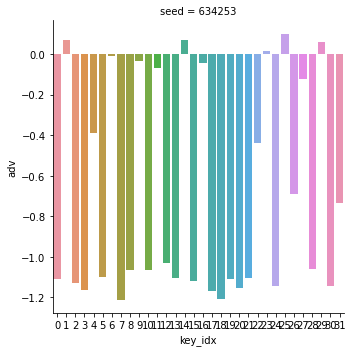

In [12]:
#ASCAD: Adapted heavily by Mahmoud Gharra

# NOTE: code could take another database if it has the same format as the one provided.
# NOTE: you need to make a local directory with the name of your chosen training_model

############################################################
############################################################
# 1st set of Hyper parameters: #############################
############################################################
# Visualization and data sampling
tot = 0 # total number of random samples that you'd like to display
f_s = 100 # frequency of data in Hz --- I can't seem to find this value in proj

# Training
tst_len = 500 # length of testing set - How many traces would you like to allocate to training?
my_seeds = [634253, 9134, 57935] # training seeds - list of seed for network to be trained on. Useful for replicating similar results.

#################################################
#################################################

# if __name__ == "__main__":

if len(sys.argv)!=2:
    ############################################################
    ############################################################
    # 2nd set of Hyper parameters:
    ############################################################
    #default parameters values
#     my_database = "../2020_APR_23/polymul32/projects/operand_scanning_32" # Loc on my personal pc
    my_database = "../chipWhisp01/projects/operand_scanning_32" # Loc on Einstein
    DB_title = "operand_scanning_32" # arbitrary name
    isASCAD = False
#     DB_title = my_database = "schoolbook32/schoolbook32"        
#     DB_title = "schoolbook32" ## Optional... It's for the graph


#     my_database = "../2020_MAR_31/ASCAD_data/ASCAD_databases/ASCAD.h5"
#     DB_title = "ASCAD"
#     isASCAD = True

    # TRAINING MODEL IS THE FILE, IN WHICH THE DATA SHOULD BE SAVED
    # Network type simply chooses the architecture according to which the data is trained
    
    # 'cnn' works well for operand_scanning_32 with 20 epochs batch 100 and 2 attempts
        
    # CNN training
    network_type = "cnn" ## ATM: you can choose between 'mlp', 'cnn', 'cnn2', and 'cnn3'
    # save folder
    training_model = "training_cnn_batch100_epochs20_MAXATT3_lr1e-3"
    
    epochs = 20
    batch_size = 100
    global MAX_ATTEMPTS_PER_KEY, drop_out, MIN_ACC
    MIN_ACC = 0.95
#     EARLY_STOP_PATIENCE = 50
    drop_out = 0.2
    MAX_ATTEMPTS_PER_KEY = 3
    LEARNING_RATE = 0.001
    ############################################################
    # Don't change anything from this point on,
    # unless you have an intuition for how the code works
    ############################################################
else:
    #get parameters from user input
    DB_title, database, training_model, network_type, epochs, batch_size= read_parameters_from_file(sys.argv[1])

# create save directory, if it doesn't exist
Path(training_model).mkdir(parents=True, exist_ok=True)
    

accuracies = {}
advantages = {}
### training
print("+ Commense training (takes about 20 seconds per epoch)")
for seed in my_seeds:
    # increasing reproducability of results according to https://keras.io/getting_started/faq/
    # set PYTHONHASHSEED before running program to increase reproducability
    # You can also consider using the CPU, as GPUs are less deterministic. (CUDA="")
    np.random.seed(seed)
    python_random.seed(seed)
    tf.random.set_random_seed(seed) # older tf versions use this
#     tf.random.set_seed(seed)

    # Train if the data_base is of type .h5 and has the structure used in ASCAD
    if isASCAD: # Change for DB_Type at some point
        # loads ASCAD traces
        print("+ Commense loading data")
        (X_profiling, Y_profiling), (X_attack, Y_attack) = load_ascad(my_database)
        global SAMPLE_HIGH
        # Organize trace data for MLP
        print("++ Organizing traces")
        SAMPLE_HIGH = X_profiling.shape[1]
        TEST_NUM = X_attack.shape[1]
        
        print("++ Profiling traces dimestions are: ", X_profiling.shape)
        # sample some traces
        print("+ sample {0} profiling traces".format(tot))
        if tot != 0:
            sample_traces(X_profiling)
            
        #get network type
        if(network_type=="mlp"):
            best_model = mlp(256)
        elif(network_type=="cnn"):
            best_model = cnn(256)
        elif(network_type=="cnn2"):
            best_model = cnn2(256)
        elif(network_type=="cnn3"):
            best_model = cnn3(256)
        else: #display an error and abort
            print("Error: no topology found for network '%s' ..." % network_type)
            sys.exit(-1);

        ### training
        history, att = train_model(X_profiling, to_categorical(Y_profiling, num_classes=256), best_model, training_model, epochs = epochs, batch_size=batch_size, seed=seed)

        # SAVE HISTORY
        save_history(training_model, history, seed=seed, att=att)
        
        # add file path to list of trained models
        models[seed] = get_file_path(training_model, MODEL_CONST, seed=seed) # TODO: models can be removed, get_file_path() is better at getting model instance
        # TODO: THE FOLLOWING 4 LINES WERE REPEATED 4 TIMES
        ## calculate test accuracy
        accuracies[seed] = calc_tst_acc(best_model, X_attack, Y_attack, seed=seed, num_classes=256)
        ## calculate ADVANTAGE
        advantages[seed] = calc_advantage(accuracies.get(seed))

    # Train if we're dealing with chip whisperer readings
    else:
        # loads cw traces
        print("+ Commense loading data")
        X, y = load_database_cw(my_database)
        print("++ Data dimestions are: ", np.array(X).shape)

        # sample some traces
        # Sampling traces intereferes with the resulting graph. This must mean that I'm doing that suboptimally
        # TODO: fix it, so that saved graph is correct
        print("+ sample {0} traces".format(tot))
        if tot != 0:
            sample_traces(X)
            print("+ print out list of categories:\n {}".format(np.unique(y)))
            print("+ print out shape of labels:\n {}".format(y.shape))
        
        for key_idx in range(KEY_LENGTH):
            print('key_idx={}...'.format(key_idx))

            #get network type
            if(network_type=="cnn"):
                best_model = cnn()
            elif(network_type=="cnn2"):
                best_model = cnn2()
            elif(network_type=="cnn3"):
                best_model = cnn3()
            elif(network_type=="mlp"):
                best_model = mlp()
            else: #display an error and abort
                print("Error: no topology found for network '%s' ..." % network_type)
                sys.exit(-1);

            # extract prof and testing data
            (X_profiling, Y_profiling), (X_testing, Y_testing) = extract_data(X, y, key_idx, best_model)


            # we run individual training for each key integer
            if models.get((seed, key_idx)) is not None:
                ## calculate ACCURACY
                accuracies[(seed, key_idx)] = calc_tst_acc(best_model, X_testing, Y_testing, seed=seed, key_idx=key_idx)
                ## calculate ADVANTAGE
                advantages[(seed, key_idx)] = calc_advantage(accuracies.get((seed, key_idx)))
                continue

            _file_path = os.path.normpath(get_file_path(training_model, MODEL_CONST, seed, key_idx))
            if os.path.exists(_file_path) == True:
                models[(seed, key_idx)] = get_file_path(training_model, MODEL_CONST, seed, key_idx)
                ## calculate ACCURACY
                accuracies[(seed, key_idx)] = calc_tst_acc(best_model, X_testing, Y_testing, seed=seed, key_idx=key_idx)
                ## calculate ADVANTAGE
                advantages[(seed, key_idx)] = calc_advantage(accuracies.get((seed, key_idx)))
                continue                

            history, att = train_model(X_profiling, to_categorical(Y_profiling, num_classes=3), best_model, training_model, seed=seed, key_idx=key_idx, epochs=epochs, batch_size=batch_size)
            
            ## TODO: save hist
            print("+ save history")
            # SAVE HISTORY
            save_history(training_model, history, seed, key_idx, att)

            # add file path to list of trained models
            models[(seed, key_idx)] = get_file_path(training_model, MODEL_CONST, seed, key_idx) # TODO: models can be removed, get_file_path() is better at getting model instance
            # TODO: THE FOLLOWING 4 LINES WERE REPEATED 4 TIMES
            ## calculate test accuracy, you'll be saving them all at the end
            accuracies[(seed, key_idx)] = calc_tst_acc(best_model, X_testing, Y_testing, seed=seed, key_idx=key_idx)
            
            ## calculate ADVANTAGE
            advantages[(seed, key_idx)] = calc_advantage(accuracies.get((seed, key_idx)))

print()
print("+ Training complete")

# Save all test accuracies and advantages
print("+ Saving dicctionary with all test accuracies and test advantages of all seeds (and keys if those exist)")
save_file(training_model, accuracies, case=TST_ACC_CONST)
save_file(training_model, advantages, case=TST_ADV_CONST)



# TODO: replace calculation of advantage with loading of it
display_results(models, accuracies, advantages, isASCAD=isASCAD)




